# Lecture 22 (5/16/2022)

**Announcements**
- Problem set 6 will be released today, due Sunday night by 11:59pm
- This week's lab + problem set covering classification in depth, meant to compliment each other


*Last time we covered:*
- Classification + CSS ethics

**Today's agenda:**
- Clustering: introduction


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering

Before we jump into clustering, it's worth doing some theoretical situating. 

What makes clustering different from the things we've talked about so far?

## *Supervised* v. *Unsupervised* learning


This week and next week, we transition to modeling techniques that have a fundamentally different approach to understanding our data.

- ***Supervised* learning**: use existing ($X$, $y$) pairs to learn relationships between $X$ and $y$ that we can apply to new data.
    - Examples: regression (continuous response variables) + classification (categorical response variables)
    - Assumptions: features $X$ have systematic relationship to a corresponding "true" (measurable) response variable $y$
    - Procedure: minimize a loss function over predictions of training data
    - In practice: requires lots of labeled data, careful procedures for evaluating generalization
- ***Unsupervised* learning**: describe structure in our data $X$ without the use of labels or output values $y$. 
    - Clustering (this week) + dimensionality reduction (next week) 
        - Note these have a kind of parallel structure to regression + classification: clustering looks for categorical structure, dimensionality reduction looks for more continuous structure
    - Assumptions: features $X$ have structure but may not map onto a particular response variable $y$
    - Procedure: identify candidate *categories* or *low-dimensional representations* in the data without any adherence to predictive accuracy (because there are no labels to predict!)
        - Note: this means we need other creative ways of assessing model "fit"; we'll look at one today
    - In practice: data no longer needs to be labeled! But can be harder to evaluate our models

There are lots of resources diving deeper into this distinction online: one nice example [here](https://towardsdatascience.com/supervised-vs-unsupervised-learning-14f68e32ea8d).

## What kind of problems can we solve with unsupervised learning?

Here, I think it's helpful to use a concrete example: movie (or music) genres.

### Supervised movie genres

Traditionally, music or movie stores are roughly organized by *genre*. One of the ways people find new books or movies they expect to enjoy is by perusing the shelves for genres they like.

Identifying music or movie genres is a kind of **supervised classification problem**. Given a large set of features like who is in a movie, who made it, even the plot summary, and a set of labeled examples, we can learn to map these features onto genre predictions. Then, when a new movie arrives on our shelves, we can predict its genre based on its features. Or, when a customer asks for a movie recommendation, we can show them movies in their favorite genres. 

![blockbuster](img/blockbuster.jpeg)

### Unsupervised movie genres

But, when you go to a streaming site like Netflix, or when Spotify tells you your "top genres", this isn't usually how they recommend new titles or music. 

Instead, they assume that there is deep structure in the ways people watch movies or the music they listen to which may not always correspond to particular *genres* but *is* helpful for organizing their movie library and identifying what people want to see or hear. 

Their recommendation systems use **unsupervised clustering and dimensionality reduction** to determine what kind of movies or music people will enjoy (note: I haven't seen how Netflix or Spotify solve these problems but this is a fairly safe assumption). 

For example, Netflix may look for ways of *clustering* their movies based on the movies people tended to watch together, then try to come up with descriptive genres after the fact ("Heart-warming family movies" or "Animated comedies"). Spotify does similar things when it describes the genres you listen to. 

![netflix](img/netflix_genres.png)

Unsupervised learning is something you encounter all the time in today's tech ecosystem. Other recommendation systems (e.g., Amazon suggesting future purchases) rely on it, as do many other algorithms that have a) rich data and b) complex behaviors or outputs that may be hard to categorize.

### Another example: margaritas?

![margaritas](img/k-margs.png)

(Source: [538](https://fivethirtyeight.com/videos/we-got-drunk-on-margaritas-for-science/))

*Why is this example here?*

Apart from being kind of funny (and recent), it actually illustrates the appeal of unsupervised clustering really well. 
- We don't have pre-existing labels for the different *types* of margaritas out there
- But we do have a lot of recipes, and we *assume* that these recipes might have some natural structure to them in terms of how they balance ingredients

Because of the above, performing traditional classification on margarita recipes seems hard (and kind of arbitrary). But, if we had some *data-driven* way of determining how the recipes cluster, we could use our human intuitions to better understand the basis for these clusters. 

So, let's see how that works (not with margaritas)!

## Clustering example: $k$-means clustering

So what does **unsupervised clustering** actually look like in practice? 

Let's go through a somewhat intuitive example that will parallel our introduction to classification: the $k$-means algorithm. 

First, let's return to familiar (and easily clusterable!) data: the `iris` dataset!

In [2]:
iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


When we use the petal length and petal width features, our data seems to cluster pretty nicely by species.

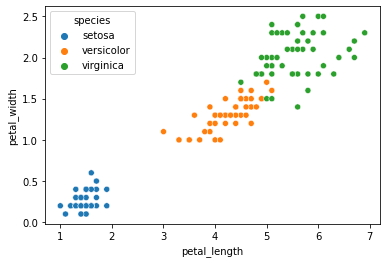

In [3]:
sns.scatterplot(data = iris, x = "petal_length", y = "petal_width", hue = "species")
plt.show()

Previously, we used our classifier to learn the species labels based on these features.

Let's say we didn't have the species information. 

We just collected this data in the field and we want to know if these variables produce detectable clusters:

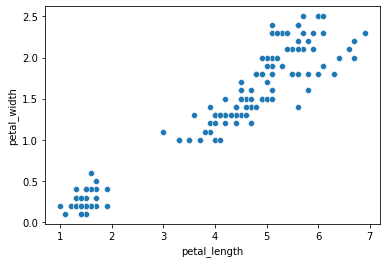

In [4]:
sns.scatterplot(data = iris, x = "petal_length", y = "petal_width")
plt.show()

**Using the data above, how might we go about suggesting clusters?**

## The $k$-means algorithm

The $k$-means algorithm has a similar name to its classification colleague, $k$-nearest neighbors, but the two have some important differences! 

Here's how $k$-means works:

![kmeans](img/kmeans.png)

(Source: [wikipedia](https://en.wikipedia.org/wiki/K-means_clustering))

**Convergence**

The "naive" $k$-means algorithm above converges when the assignments no longer change from the previous step. 



## "Brute force" $k$-means

Below, I'm going to walk through some (very clunky) code that implements $k$-means clustering in the `iris` data by *brute force*, assuming there are 3 clusters. 

*Why?* Doing this will illustrate how the steps above in "plain English" map onto actual code behaviors (sometimes this mapping is tricky and is in general one of the more challenging things about learning to code, so practice is good!).



In [5]:
# Pick 3 random starting "centers"
centers = iris.sample(n = 3).reset_index(drop = True)
centers
c1 = centers.loc[0, :]
c2 = centers.loc[1, :]
c3 = centers.loc[2, :]

# Let's generate our initial cluster assignment
iris['clusters'] = np.repeat("c2", len(iris)) # this is just a stand-in. Bit hacky...

# Keep track of clusters from previous iteration to assess convergence
prev_clusters = np.repeat("c1", len(iris)) # this is just a stand-in. Also hacky...

# Function to figure out the closest centroid to each data point
def get_closest(df):
    # This is just the Euclidean distance from the datapoint in `df` to each centroid c1, c2, and c3
    dist1 = np.sqrt(((df.petal_length - c1.petal_length)**2) + ((df.petal_width - c1.petal_width)**2))
    dist2 = np.sqrt(((df.petal_length - c2.petal_length)**2) + ((df.petal_width - c2.petal_width)**2))
    dist3 = np.sqrt(((df.petal_length - c3.petal_length)**2) + ((df.petal_width - c3.petal_width)**2))
    # Now, what's the minimum of the distances above? Return the centroid that is closest
    check = min(dist1, dist2, dist3)
    if check == dist1:
        return "c1"
    elif check == dist2:
        return "c2"
    elif check == dist3:
        return "c3"

# Run actual k-means
iter_num = 0 # this is just to keep track of how many times our `while` loop below is running
while list(iris.clusters) != list(prev_clusters) and iter_num < 100:
    iter_num += 1
    prev_clusters = iris['clusters']
    # Find closest cluster center for each datapoint
    iris['clusters'] = iris.apply(get_closest, axis = 1)
    
    # Get the data belonging to each centroid and calculate the new centers
    c1_dat = iris.loc[iris.clusters == "c1", :]
    c2_dat = iris.loc[iris.clusters == "c2", :]
    c3_dat = iris.loc[iris.clusters == "c3", :]
    # c1 center update
    c1.loc["petal_length"] = c1_dat.petal_length.mean()
    c1.loc["petal_width"] = c1_dat.petal_width.mean()
    # c2 center update
    c2.loc["petal_length"] = c2_dat.petal_length.mean()
    c2.loc["petal_width"] = c2_dat.petal_width.mean()
    # c3 center update
    c3.loc["petal_length"] = c3_dat.petal_length.mean()
    c3.loc["petal_width"] = c3_dat.petal_width.mean()


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-5-f18999cf69df>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c1.loc["petal_length"] = c1_dat.petal_length.mean()
<ipython-input-5-f18999cf69df>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c1.loc["petal_width"] = c1_dat.petal_width.mean()
<ipython-input

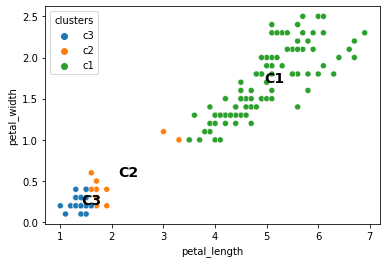

In [6]:
sns.scatterplot(data = iris, x = "petal_length", y = "petal_width", hue = "clusters")

plt.text(c1.petal_length, c1.petal_width, s = "C1", fontsize = 14, fontweight = "bold")
plt.text(c2.petal_length, c2.petal_width, s = "C2", fontsize = 14, fontweight = "bold")
plt.text(c3.petal_length, c3.petal_width, s = "C3", fontsize = 14, fontweight = "bold")

plt.show()

When we run the above code a bunch of different times, does it always do the same thing?

In [7]:
# Go up and run the k-means clustering code above, then come back and print iter_num again
iter_num

2

One vulnerability of $k$-means clustering is that it can depend on the *seed* or the elements you initially assign to each cluster, which are randomly chosen. 

The sklearn solution (below) includes an `n_init` argument with a default value of 10. This runs the clustering algorithm 10 consecutive times and chooses the best one according to a metric called *inertia*. 

Let's see what else it can do!

## $k$-means in python

Let's take a look at the scikit-learn `KMeans` class [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [8]:
# Import the KMeans class from sklearn
from sklearn.cluster import KMeans

# Get our features (now we don't have corresponding labels!)
x_vals = np.array(iris[['petal_length', 'petal_width']]).reshape(len(iris), 2)

# Initialize the model
kmeans = KMeans(n_clusters = 3, # default value is 8
                random_state = 1)

# Fit the model to our data
kmeans.fit(X = x_vals)

kmeans

KMeans(n_clusters=3, random_state=1)

### `KMeans` attributes

What attributes does the `KMeans` class export?

- cluster centers
- labels
- iterations
- *inertia*

**Cluster centers**

In [9]:
# The cluster centers estimated by our k-means clustering
kmeans.cluster_centers_

array([[5.59583333, 2.0375    ],
       [1.462     , 0.246     ],
       [4.26923077, 1.34230769]])

<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

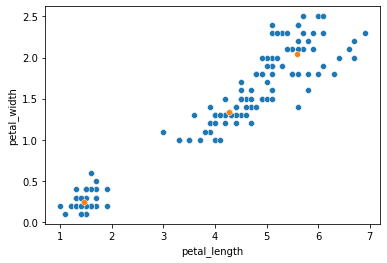

In [10]:
# Let's pull out these cluster centers
x_center = []
y_center = []
for elem in kmeans.cluster_centers_:
    x_center.append(elem[0])
    y_center.append(elem[1])

sns.scatterplot(data = iris, x = "petal_length", y = "petal_width")
sns.scatterplot(x = x_center, y = y_center)

**Labels**

In [11]:
# The labels applied to our X data
kmeans.labels_

# len(kmeans.labels_)
# len(x_vals)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

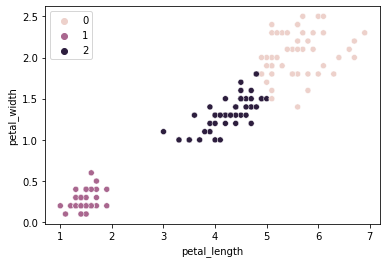

In [12]:
sns.scatterplot(data = iris, x = "petal_length", y = "petal_width", hue = kmeans.labels_)
plt.show()

How does this compare to our empirical species labels?

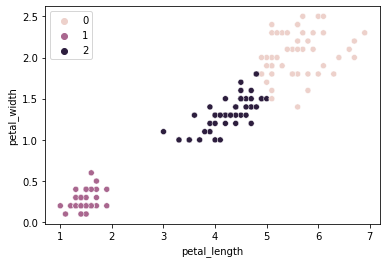

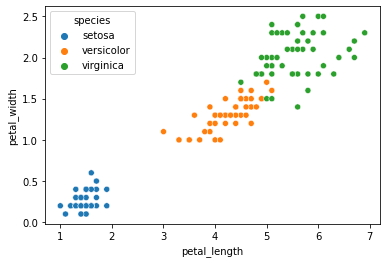

In [13]:
sns.scatterplot(data = iris, x = "petal_length", y = "petal_width", hue = kmeans.labels_)
plt.show()

sns.scatterplot(data = iris, x = "petal_length", y = "petal_width", hue = "species")
plt.show()

That's COOL! 

Now it's your turn! 

Try the above with only two clusters. Does it do the thing we expect? What about 8 clusters?

In [14]:
### YOUR CODE HERE




**Iterations and Intertia**

As we discussed when setting up the algorithm, it runs a certain number of times until *convergence*, and this can vary depending on which elements are chosen as the starting *seeds*. 

The `KMeans` class has attributes that let you check how it did: in the best run, how many iterations did it do, and how successful were they?

- `n_iter_` tells you how many iterations the algorithm underwent until convergence
- `inertia_` tells you the sum of squared distances of samples to their closest cluster center. So lower is better here.

Critically, these values are the *best* ones chosen from across `n_init` runs of the algorithm.

In [15]:
kmeans.n_iter_
kmeans.inertia_

31.371358974358966

We can change this value, though with data that clusters this well, it doesn't seem to impact us too much...

<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

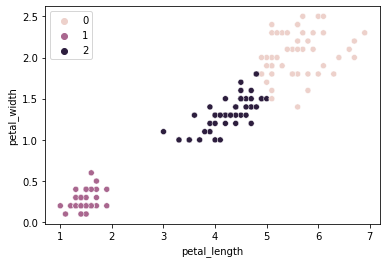

In [16]:
kmeans_quick = KMeans(n_clusters = 3,
                      n_init = 1, # NOTE: changing this param
                      random_state = 1).fit(X = x_vals)

sns.scatterplot(data = iris, x = "petal_length", y = "petal_width", hue = kmeans_quick.labels_)

In [17]:
kmeans_quick.inertia_

31.371358974358966

## Evaluating $k$-means clustering: how many clusters?

The *within cluster sum of squared distance to the center* is one way of evaluating our $k$-means clustering. 

The `inertia_` attribute for the `KMeans` class gives us this, as does the `score` function (this gives us negative inertia technically). 

Below, we plot the inertia for $k$-means going from 1-10 in the `iris` data from above. 

One way to choose the number of clusters is to find the point where our *inertia* isn't getting any lower even as we add more clusters.

<AxesSubplot:>

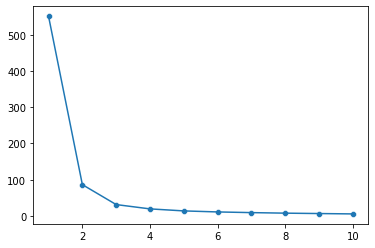

In [18]:
kmeans = np.arange(1, 11)
inertias = []

for x in kmeans:
    inertias.append(
        KMeans(n_clusters = x, random_state = 1).fit(X = x_vals).inertia_
    )


sns.scatterplot(x = kmeans, y = inertias)
sns.lineplot(x = kmeans, y = inertias)

In the figure above, we can see that 2-3 clusters is probably ideal for this data. 

# Summary

This is meant to introduce the idea of unsupervised clustering and give you a feel for how it works with $k$-means clustering. 

In the remainder of this week, we'll follow a similar structure to our regression and classification units: what other clustering solutions are out there and how do we evaluate them?